# IGNORA QUESTO FILE!!!

### Library imports and network loading

In [1]:
import networkx as nx   # Key library for network analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# Load datasets
meetings_file = r'..\Dataset\Anonymized\Montagna_meetings_edgelist.csv'
df_meetings = pd.read_csv(meetings_file, sep='\t', header=None, names=['Source', 'Target', 'Weight'])
calls_file = r'..\Dataset\Anonymized\Montagna_phonecalls_edgelist.csv'
df_calls = pd.read_csv(calls_file, sep='\t', header=None, names=['Source', 'Target', 'Weight'])

In [31]:
# Load networks from DataFrames
G_meetings = nx.Graph()
G_meetings.add_weighted_edges_from(df_meetings.values)
G_calls = nx.Graph()
G_calls.add_weighted_edges_from(df_calls.values)

### Plot the separated networks

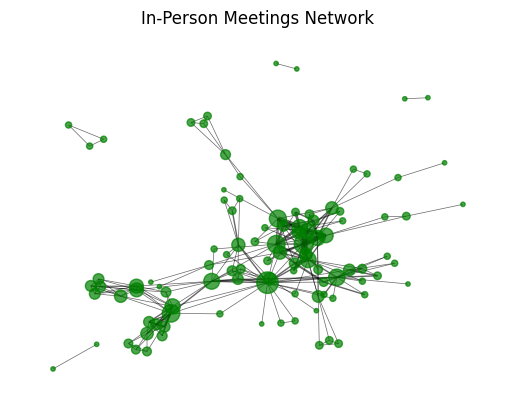

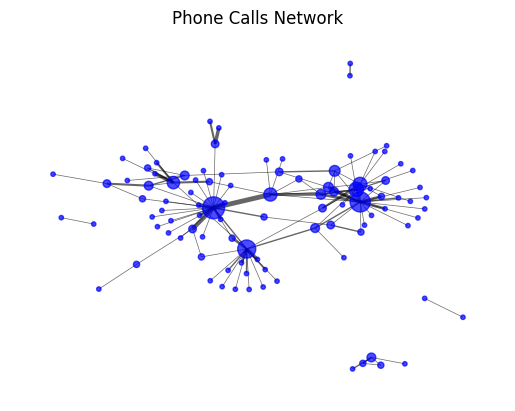

In [32]:
# Function to draw graphs. Scales node sizes by degree and edge widths by weight
def draw_graph(G, title, node_color='lightgray', edge_color='black'):
    degrees = dict(G.degree())
    node_sizes = [degrees[n] * 10 for n in G.nodes()]  # Node size scaled by degree (scale factor = 10, can be adjusted)
    
    edge_weights = [G[u][v].get('weight', 1) * 0.5 for u, v in G.edges()]   # Edge width scaled by weight (scale factor = 0.5, can be adjusted)

    pos = nx.spring_layout(G, k=0.22, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_color, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.show()

draw_graph(G_meetings, "In-Person Meetings Network", node_color='green')
draw_graph(G_calls, "Phone Calls Network", node_color='blue')

### Combined Graph

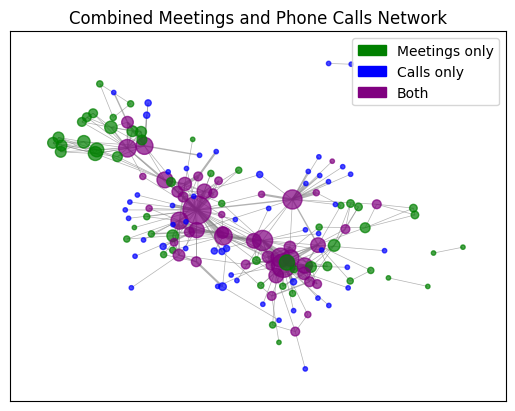

In [34]:
# Combine the two graphs
G_combined = nx.Graph()
G_combined.add_edges_from(G_meetings.edges(data=True))  # data=True carries edge attributes (weights)
G_combined.add_edges_from(G_calls.edges(data=True))     # Adds edges that are not already in the graph. Nodes in common are merged.

# Classify nodes
nodes_meetings = set(G_meetings.nodes())
nodes_calls = set(G_calls.nodes())

node_colors = {}
for node in G_combined.nodes():
    in_meetings = node in nodes_meetings
    in_calls = node in nodes_calls
    if in_meetings and in_calls:
        node_colors[node] = 'purple'  # both
    elif in_meetings:
        node_colors[node] = 'green'   # only meetings
    elif in_calls:
        node_colors[node] = 'blue'    # only calls

# Node sizes (scaled by degree)
degrees = dict(G_combined.degree())
node_sizes = [degrees[n] * 10 for n in G_combined.nodes()]  # scale factor = 10 (maybe change?)
# Edge thickness (scaled by weight)
edge_weights = [G_combined[u][v].get('weight', 1) * 0.5 for u, v in G_combined.edges()]  # scale factor = 0.5 (maybe change?)

pos = nx.spring_layout(G_combined, k=0.22, seed=42)  # Positions the nodes, using a certain layout ('spring'). k influences the distance between nodes

# Draw combined graph
nx.draw_networkx_nodes(G_combined, pos, node_color=[node_colors[n] for n in G_combined.nodes()], node_size=node_sizes, alpha=0.7)
nx.draw_networkx_edges(G_combined, pos, width=edge_weights, edge_color='gray', alpha=0.6)
#nx.draw_networkx_labels(G_combined, pos, font_size=8)

# Add legend
import matplotlib.patches as mpatches
legend = [mpatches.Patch(color='green', label='Meetings only'),
          mpatches.Patch(color='blue', label='Calls only'),
          mpatches.Patch(color='purple', label='Both')]
plt.legend(handles=legend)
plt.title("Combined Meetings and Phone Calls Network")
plt.show()


### Graph analysis

In [35]:
# Function to print graph statistics. Statistics include:
# - Number of nodes, edges, and connected components
# - Max and average edge weight
# - Max and average node degree
# - Max shortest path length ("diameter") - Note: computes the diameter of the largest connected component
def print_graph_stats(G, name="Graph"):
    print(f"--- {name} ---")
    
    # Basic info (number of nodes, edges and components)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    print(f"Nodes: {num_nodes}")
    print(f"Edges: {num_edges}")
    print(f"Connected components: {num_components}")
    
    # Edge weights
    edge_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]
    max_weight = max(edge_weights)
    avg_weight = np.mean(edge_weights)
    print(f"Max edge weight: {max_weight}")
    print(f"Average edge weight: {avg_weight:.2f}")

    # Node degrees
    degrees = dict(G.degree())
    max_degree = max(degrees.values())
    avg_degree = np.mean(list(degrees.values()))
    print(f"Max node degree: {max_degree}")
    print(f"Average node degree: {avg_degree:.2f}")

    # Shortest path stats
    if nx.is_connected(G):  # Our graphs are disconnected, so this piece is always skipped
        diameter = nx.diameter(G)
    else:                   # Work on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc)
        diameter = nx.diameter(G_sub)
    print(f"Max shortest path length (diameter): {diameter}")
    
    print()  # Blank line for readability

In [37]:
print_graph_stats(G_meetings, name="Meetings Network")
print_graph_stats(G_calls, name="Phone Calls Network")

--- Meetings Network ---
Nodes: 101
Edges: 256
Connected components: 5
Max edge weight: 10
Average edge weight: 1.44
Max node degree: 24
Average node degree: 5.07
Max shortest path length (diameter): 7

--- Phone Calls Network ---
Nodes: 100
Edges: 124
Connected components: 5
Max edge weight: 7
Average edge weight: 1.69
Max node degree: 25
Average node degree: 2.48
Max shortest path length (diameter): 7



In [11]:
print_graph_stats(G_combined, name="Combined Network")  # Note: there are 47 nodes *in common* between the two networks

--- Combined Network ---
Nodes: 154
Edges: 342
Connected components: 5
Max edge weight: 7
Average edge weight: 1.44
Max node degree: 41
Average node degree: 4.44
Max shortest path length (diameter): 7



In [38]:
# Count common nodes
common_nodes = set(G_meetings.nodes()).intersection(set(G_calls.nodes()))
print(f"Number of common nodes: {len(common_nodes)}")

Number of common nodes: 47


In [42]:
def all_component_diameters(G):
    for i, component in enumerate(nx.connected_components(G)):
        sub = G.subgraph(component)
        if len(sub) > 1:
            diam = nx.diameter(sub)
            print(f"Component {i+1}: size={len(sub)}, diameter={diam}")
all_component_diameters(G_calls)
print("")
all_component_diameters(G_meetings)

Component 1: size=2, diameter=1
Component 2: size=89, diameter=7
Component 3: size=2, diameter=1
Component 4: size=2, diameter=1
Component 5: size=5, diameter=2

Component 1: size=3, diameter=1
Component 2: size=92, diameter=7
Component 3: size=2, diameter=1
Component 4: size=2, diameter=1
Component 5: size=2, diameter=1


### Further analysis

In [ ]:
# Idk forse fare i vari tipi di centrality, la più adatta dovrebbe essere la betweenness centrality

# FILE SBAGLIATO, PASSARE AL PROGETTO COL DATASET COMPLETO